## FRAUD DETECTION IN ELECTRICITY AND GAS CONSUMPTION CHALLENGE

* Import Libraries
* Basic EDA
* feature Engineering
* Modelling
* Prediction
* Submission

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import time

seed = 47


In [4]:
invoice_test = pd.read_csv("../test/invoice_test.csv")

invoice_train = pd.read_csv("../train/invoice_train.csv")

client_test = pd.read_csv("../test/client_test.csv")
client_train = pd.read_csv("../train/client_train.csv")

/tmp/ipykernel_139139/998130178.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv("../train/invoice_train.csv")


Exploratory Data Analysis

In [6]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [7]:
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [8]:
client_train.shape

(135493, 6)

There are 135493 rows and 6 columns in the client_train dataset.

Grouping by target and client_id in the client_train dataset

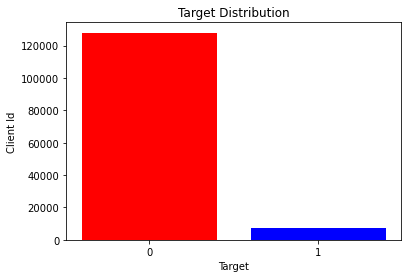

In [12]:
df_client_train = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=df_client_train.index, height=df_client_train.values, tick_label=[0,1], color=['red', 'blue'])
plt.title('Target Distribution')
plt.ylabel("Client Id")
plt.xlabel("Target")
plt.show()